# Subgroups

This is the fifth in a series of notebooks that make up a [case study on classification and algorithmic fairness](https://allendowney.github.io/RecidivismCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.
[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/05_subgroups.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/v1/utils.py"
)

<IPython.core.display.Javascript object>

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.  The following cell downloads the data file we'll use directly from their repository.

In [2]:
download(
    "https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv"
)

<IPython.core.display.Javascript object>

The following cell read the data file:

In [3]:
import pandas as pd

cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

<IPython.core.display.Javascript object>

## The reference class problem

In the first notebook we replicated the analysis in the ProPublica article and computed various metrics of accuracy for white and black defendants.  We found that the predictive values (PPV and NPV) were similar for the two groups, but the error rates (FPR and FNR) were substantially different.

In the previous notebook, we ran the same analysis for male and female defendants and found the opposite pattern: the error rates are about the same, but the predictive values are different.

Neither scenario seems completely fair.  Comparing black and white defendants:

* Among non-recidivists, black defendants were more likely to be classified as high risk (false positive).

* Among recidivists, white defendants were more likely to be classified as low risk (false negative).

Comparing male and female defendants:

* Among defendants classified as high risk, female defendants were less likely to recidivate; that is, the test has lower PPV for women.

* Among defendants classified as low risk, male defendants were less likely to "survive"; that is, the test has lower NPV for men.

So it seems like we can't win.  If predictive values are the same for all groups, error rates are not (in general).  And if error rates are the same, predictive values are not.

Nevertheless, the designers of a test like COMPAS can make trade-offs among these kinds of errors.  And that raises two questions I would like to explore:

1. What kind of fairness is COMPAS designed to achieve?  Are they trying to make predictive value the same for all groups?  Or error rates?  Or some compromise?

2. What kind of fairness *should* a test like COMPAS achieve?

To explore the first question, I will compute accuracy metrics for defendants grouped by age, race, and sex, and for the intersections of these groups (explained below).

## Groups

The following function takes a DataFrame containing COMPAS data and a list of variables to group by.  It returns a table with one row for each group and one column for each accuracy metric.

In [4]:
from utils import make_matrix
from utils import compute_metrics


def make_table(cp, group_vars):
    """Make a table of metrics for each subgroup.

    cp: DataFrame of COMPAS data
    group_vars: string or list of variable names to group by

    returns: DataFrame
    """
    # count the number of defendants in each group
    grouped = cp.groupby(group_vars)
    counts = grouped["id"].count()

    # make the table
    columns = ["FPR", "FNR", "PPV", "NPV", "Prevalence"]
    table = pd.DataFrame(index=counts.index, columns=columns, dtype=float)

    # fill in the table
    for name, group in grouped:
        if len(group) < 50:
            continue
        m = make_matrix(group)
        metrics = compute_metrics(m)
        table.loc[name] = metrics["Percent"]

    table["Count"] = counts
    return table

<IPython.core.display.Javascript object>

Here's the table for defendants grouped by race.

In [5]:
table1 = make_table(cp, "race")
table1

,FPR,FNR,PPV,NPV,Prevalence,Count
race,,,,,,
African-American,44.8,28.0,63.0,65.0,51.4,3696
Asian,NaN,NaN,NaN,NaN,NaN,32
Caucasian,23.5,47.7,59.1,71.2,39.4,2454
Hispanic,21.5,55.6,54.2,71.1,36.4,637
Native American,NaN,NaN,NaN,NaN,NaN,18
Other,14.8,67.7,54.4,69.8,35.3,377


<IPython.core.display.Javascript object>

Some rows contain `NaN` values because I did not compute metrics for groups with fewer than 50 defendants.

`table1` confirms results from previous analysis and extends them to other groups:

* Predicive values are comparable for all racial groups, although PPV is highest for black defendants and NPV is lowest.

* Error rates are substantially different in different groups.  FPR is highest for black defendants, lower for white and Hispanic defendants, and lowest for defendants in other racial groups.  FNR is highest for Other and lowest for African-American.

The following table shows the breakdown by sex.

In [6]:
table2 = make_table(cp, "sex")
table2

,FPR,FNR,PPV,NPV,Prevalence,Count
sex,,,,,,
Female,32.1,39.2,51.3,75.7,35.7,1395
Male,32.4,37.1,63.5,67.0,47.3,5819


<IPython.core.display.Javascript object>

Again, these results are consistent with previous analysis.  Comparing male and female defendants, the error rates are comparable, but the predictive values are substantially different.

Next we'll look at the breakdown by age, but first I'll recode the age categories so their ordering in the table is more logical:

In [7]:
cp["age_cat"].value_counts().index

Index(['25 - 45', 'Greater than 45', 'Less than 25'], dtype='object', name='age_cat')

<IPython.core.display.Javascript object>

In [8]:
d = {
    "Less than 25": "1 Younger than 25",
    "25 - 45": "2 Between 25 - 45",
    "Greater than 45": "3 Older than 45",
}
cp["age_cat_recode"] = cp["age_cat"].replace(d)

<IPython.core.display.Javascript object>

Here's the breakdown by age group:

In [9]:
table3 = make_table(cp, "age_cat_recode")
table3

,FPR,FNR,PPV,NPV,Prevalence,Count
age_cat_recode,,,,,,
1 Younger than 25,54.1,26.0,64.0,57.5,56.5,1529
2 Between 25 - 45,33.4,37.4,61.5,67.7,46.0,4109
3 Older than 45,16.8,57.2,54.1,75.9,31.6,1576


<IPython.core.display.Javascript object>

This table shows some patterns we have seen before 

* In groups with high prevalence, FPR is relatively high and FNR relatively low.

* In groups with high prevalence, PPV is relatively hight and NPV relatively low.

But it is still not clear whether COMPAS is trying to achieve constant error rates, constant predictive values, or a compromise between the two.

It is also not clear what we can say about defendants in the intersections of these groups.  What are the metrics for a white male, or an older Hispanic defendant?

I'll compute these intersections in the next section.

## Intersections

In this section I'll compute metrics for defendants grouped by

* Race and sex

* Race and age

* Sex and age

* Race, sex, and age

Then we'll plot the results.

In [10]:
table4 = make_table(cp, ["race", "sex"])
table4

FPR   FNR   PPV   NPV  Prevalence  Count
race             sex                                              
African-American Female  40.5  30.0  51.3  76.5        37.9    652
                 Male    46.1  27.7  65.1  62.1        54.3   3044
Asian            Female   NaN   NaN   NaN   NaN         NaN      2
                 Male     NaN   NaN   NaN   NaN         NaN     30
Caucasian        Female  30.2  43.2  50.4  74.9        35.1    567
                 Male    21.2  48.9  62.2  70.2        40.6   1887
Hispanic         Female  10.0  72.7  56.2  72.4        32.0    103
                 Male    23.9  52.8  54.0  70.8        37.3    534
Native American  Female   NaN   NaN   NaN   NaN         NaN      4
                 Male     NaN   NaN   NaN   NaN         NaN     14
Other            Female  11.5  66.7  45.5  82.1        22.4     67
                 Male    15.6  67.8  55.9  66.9        38.1    310

<IPython.core.display.Javascript object>

In [11]:
table5 = make_table(cp, ["race", "age_cat_recode"])
table5

FPR   FNR   PPV   NPV  Prevalence  Count
race             age_cat_recode                                              
African-American 1 Younger than 25  59.9  23.2  66.7  52.6        61.0    920
                 2 Between 25 - 45  44.1  27.7  62.7  66.4        50.6   2194
                 3 Older than 45    31.8  41.3  54.7  71.6        39.5    582
Asian            1 Younger than 25   NaN   NaN   NaN   NaN         NaN      7
                 2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN     14
                 3 Older than 45     NaN   NaN   NaN   NaN         NaN     11
Caucasian        1 Younger than 25  48.7  26.7  59.1  66.7        49.0    390
                 2 Between 25 - 45  26.8  47.0  60.0  67.2        43.1   1312
                 3 Older than 45     9.6  68.9  55.6  77.3        27.8    752
Hispanic         1 Younger than 25  47.5  36.4  59.2  57.1        52.0    127
                 2 Between 25 - 45  18.5  59.3  56.1  70.3        36.8    367
                 3 Older than 45    13.4  80.6  28.6  79.5        21.7    143
Native American  1 Younger than 25   NaN   NaN   NaN   NaN         NaN      3
                 2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN     12
                 3 Older than 45     NaN   NaN   NaN   NaN         NaN      3
Other            1 Younger than 25  45.2  47.5  52.5  54.8        48.8     82
                 2 Between 25 - 45  10.8  73.2  55.9  70.5        33.8    210
                 3 Older than 45     3.2  86.4  60.0  76.2        25.9     85

<IPython.core.display.Javascript object>

In [12]:
table6 = make_table(cp, ["sex", "age_cat"])
table6

FPR   FNR   PPV   NPV  Prevalence  Count
sex    age_cat                                                   
Female 25 - 45          29.4  40.8  56.2  73.1        38.9    807
       Greater than 45  15.3  66.2  40.7  80.5        23.7    300
       Less than 25     61.7  17.7  46.3  77.0        39.2    288
Male   25 - 45          34.5  36.7  62.6  66.2        47.7   3302
       Greater than 45  17.2  55.7  56.4  74.7        33.5   1276
       Less than 25     51.4  27.3  68.4  53.7        60.5   1241

<IPython.core.display.Javascript object>

In [13]:
table7 = make_table(cp, ["race", "sex", "age_cat_recode"])
table7

FPR   FNR   PPV   NPV  Prevalence  \
race             sex    age_cat_recode                                          
African-American Female 1 Younger than 25  63.4  19.7  50.8  69.4        45.0   
                        2 Between 25 - 45  36.5  34.4  52.7  74.9        38.2   
                        3 Older than 45    23.5  35.0  44.8  88.1        22.7   
                 Male   1 Younger than 25  58.6  23.7  70.3  48.9        64.6   
                        2 Between 25 - 45  46.3  26.6  64.4  63.9        53.3   
                        3 Older than 45    33.8  41.9  56.0  68.1        42.5   
Asian            Female 2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN   
                        3 Older than 45     NaN   NaN   NaN   NaN         NaN   
                 Male   1 Younger than 25   NaN   NaN   NaN   NaN         NaN   
                        2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN   
                        3 Older than 45     NaN   NaN   NaN   NaN         NaN   
Caucasian        Female 1 Younger than 25  70.0   3.7  38.2  94.7        31.0   
                        2 Between 25 - 45  29.2  41.2  59.7  70.0        42.4   
                        3 Older than 45    13.1  75.6  37.0  78.5        24.0   
                 Male   1 Younger than 25  39.6  30.5  67.5  62.7        54.1   
                        2 Between 25 - 45  26.1  48.7  60.1  66.5        43.4   
                        3 Older than 45     8.5  67.3  61.1  77.0        28.9   
Hispanic         Female 1 Younger than 25   NaN   NaN   NaN   NaN         NaN   
                        2 Between 25 - 45   7.1  81.0  57.1  69.6        33.3   
                        3 Older than 45     NaN   NaN   NaN   NaN         NaN   
                 Male   1 Younger than 25  52.9  37.3  57.8  52.2        53.6   
                        2 Between 25 - 45  21.1  55.3  56.0  70.4        37.5   
                        3 Older than 45    13.8  76.9  31.6  80.2        21.7   
Native American  Female 2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN   
                        3 Older than 45     NaN   NaN   NaN   NaN         NaN   
                 Male   1 Younger than 25   NaN   NaN   NaN   NaN         NaN   
                        2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN   
                        3 Older than 45     NaN   NaN   NaN   NaN         NaN   
Other            Female 1 Younger than 25   NaN   NaN   NaN   NaN         NaN   
                        2 Between 25 - 45   NaN   NaN   NaN   NaN         NaN   
                        3 Older than 45     NaN   NaN   NaN   NaN         NaN   
                 Male   1 Younger than 25  46.7  45.9  58.8  48.5        55.2   
                        2 Between 25 - 45  12.6  75.8  51.7  67.4        35.8   
                        3 Older than 45     3.9  84.2  60.0  75.4        27.1   

                                           Count  
race             sex    age_cat_recode            
African-American Female 1 Younger than 25    169  
                        2 Between 25 - 45    395  
                        3 Older than 45       88  
                 Male   1 Younger than 25    751  
                        2 Between 25 - 45   1799  
                        3 Older than 45      494  
Asian            Female 2 Between 25 - 45      1  
                        3 Older than 45        1  
                 Male   1 Younger than 25      7  
                        2 Between 25 - 45     13  
                        3 Older than 45       10  
Caucasian        Female 1 Younger than 25     87  
                        2 Between 25 - 45    309  
                        3 Older than 45      171  
                 Male   1 Younger than 25    303  
                        2 Between 25 - 45   1003  
                        3 Older than 45      581  
Hispanic         Female 1 Younger than 25     17  
                        2 Between 25 - 45     63  
                        3 Older than 45       23  
     

<IPython.core.display.Javascript object>

These tables show how much these metrics vary between groups:

* 

In [14]:
tables = [table1, table2, table3, table4, table5, table6, table7]

all_groups = pd.concat(tables)
len(all_groups)

81

<IPython.core.display.Javascript object>

In [15]:
all_groups.describe()

,FPR,FNR,PPV,NPV,Prevalence,Count
count,54.000000,54.000000,54.000000,54.000000,54.000000,81.000000
mean,30.520370,47.648148,55.611111,69.603704,40.094444,623.432099
std,17.339761,19.922603,8.655256,9.204490,10.987015,1059.278516
min,3.200000,3.700000,28.600000,48.500000,21.700000,1.000000
25%,15.375000,31.475000,52.550000,66.425000,33.350000,15.000000
50%,29.300000,44.550000,56.200000,70.250000,38.550000,169.000000
75%,45.100000,66.575000,60.850000,75.625000,48.525000,652.000000
max,70.000000,86.400000,70.300000,94.700000,64.600000,5819.000000


<IPython.core.display.Javascript object>

In [16]:
def min_max_metric(all_groups, metric):
    """ """
    idx = all_groups[metric].idxmax()
    print(idx, all_groups[metric][idx])

    idx = all_groups[metric].idxmin()
    print(idx, all_groups[metric][idx])

<IPython.core.display.Javascript object>

Here are the groups with maximumn and minimum FPR:

In [17]:
min_max_metric(all_groups, "FPR")

('Caucasian', 'Female', '1 Younger than 25') 70.0
('Other', '3 Older than 45') 3.2


<IPython.core.display.Javascript object>

And here are the results for the other metrics:

In [18]:
min_max_metric(all_groups, "FNR")

('Other', '3 Older than 45') 86.4
('Caucasian', 'Female', '1 Younger than 25') 3.7


<IPython.core.display.Javascript object>

In [19]:
min_max_metric(all_groups, "PPV")

('African-American', 'Male', '1 Younger than 25') 70.3
('Hispanic', '3 Older than 45') 28.6


<IPython.core.display.Javascript object>

In [20]:
min_max_metric(all_groups, "NPV")

('Caucasian', 'Female', '1 Younger than 25') 94.7
('Other', 'Male', '1 Younger than 25') 48.5


<IPython.core.display.Javascript object>

In [21]:
min_max_metric(all_groups, "Prevalence")

('African-American', 'Male', '1 Younger than 25') 64.6
('Hispanic', '3 Older than 45') 21.7


<IPython.core.display.Javascript object>

Looking at these results, I have a few thoughts:

1. The differences between groups are big.  FNR, which ranges from about 4% to 86%, is particularly striking.

2. For some metrics the most extreme groups are relatively small groups, so that might not be meaningful.  Statistically it is easier for a small group to deviate from the overall averages.

3. It is not clear from these results how much of the variation between groups is due to differences in prevalance.  I'll explore this relationship in the next section.




## Reverse engineering



In [22]:
from utils import predictive_value
from utils import error_rates

matrix_all = make_matrix(cp)
ppv, npv = predictive_value(matrix_all)
fpr, fnr = error_rates(matrix_all)

<IPython.core.display.Javascript object>

In [23]:
import numpy as np
from utils import constant_error_rates

prevalences = np.linspace(20, 65, 11)

pred_pv = pd.DataFrame(columns=["ppv", "npv"])

for prev in prevalences:
    m = constant_error_rates(fpr, fnr, prev)
    pred_pv.loc[prev] = predictive_value(m)

pred_pv

,ppv,npv
20.0,62.596124,67.65077
24.5,62.596124,67.65077
29.0,62.596124,67.65077
33.5,62.596124,67.65077
38.0,62.596124,67.65077
42.5,62.596124,67.65077
47.0,62.596124,67.65077
51.5,62.596124,67.65077
56.0,62.596124,67.65077
60.5,62.596124,67.65077


<IPython.core.display.Javascript object>

In [24]:
from utils import constant_predictive_value

prevalences = np.linspace(35, 55, 11)

pred_er = pd.DataFrame(columns=["FPR", "FNR"])

for prev in prevalences:
    m = constant_predictive_value(ppv, npv, prev)
    pred_er.loc[prev] = error_rates(m)

pred_er

,FPR,FNR
35.0,31.20349,38.649382
37.0,31.20349,38.649382
39.0,31.20349,38.649382
41.0,31.20349,38.649382
43.0,31.20349,38.649382
45.0,31.20349,38.649382
47.0,31.20349,38.649382
49.0,31.20349,38.649382
51.0,31.20349,38.649382
53.0,31.20349,38.649382


<IPython.core.display.Javascript object>

In [25]:
from utils import plot_cpv_model

<IPython.core.display.Javascript object>

In [26]:
from utils import plot_cer_model

<IPython.core.display.Javascript object>

Those are all the possible subgroups for these three variables.

Now we can see what the results look like.

The following function plots one data point per subgroup showing the given metric versus prevalence.

Groups with a small number of people are shown with lighter colors.


In [27]:
import matplotlib.pyplot as plt


def plot_table_var(table, var, color):
    """Plot one data point per row.

    table: DataFrame
    var: which metric to plot
    color: string
    """
    plt.plot(table["Prevalence"], table[var], "o", color=color, alpha=0.6)

<IPython.core.display.Javascript object>

Here's what the results look like for FPR.

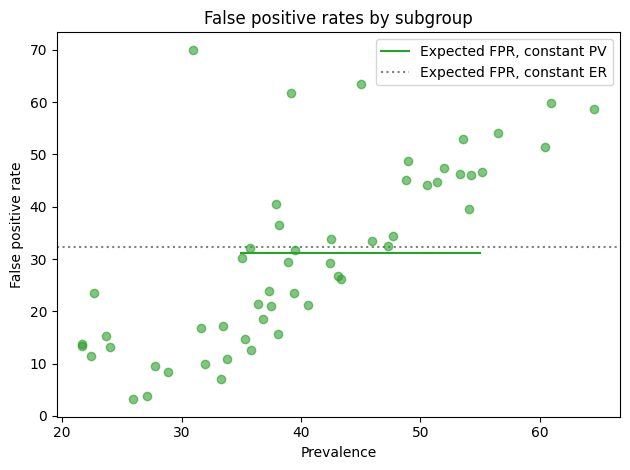

<IPython.core.display.Javascript object>

In [28]:
from utils import decorate

pred_er["FPR"].plot(label="Expected FPR, constant PV", color="C2")
plt.axhline(fpr, linestyle="dotted", color="gray", label="Expected FPR, constant ER")

for table in tables:
    plot_table_var(table, "FPR", "C2")

decorate(
    xlabel="Prevalence",
    ylabel="False positive rate",
    title="False positive rates by subgroup",
)

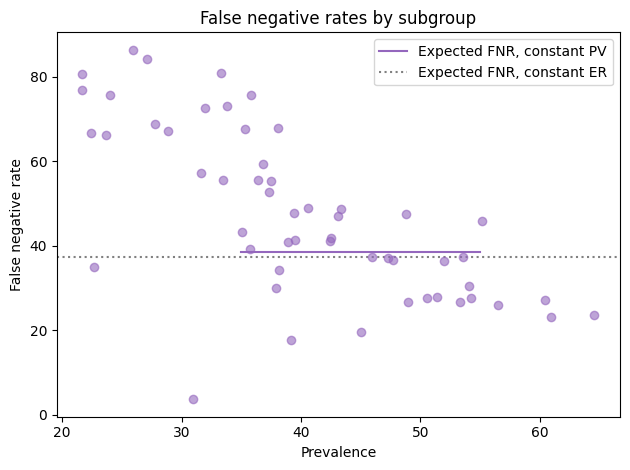

<IPython.core.display.Javascript object>

In [29]:
pred_er["FNR"].plot(label="Expected FNR, constant PV", color="C4")
plt.axhline(fnr, linestyle="dotted", color="gray", label="Expected FNR, constant ER")

for table in tables:
    plot_table_var(table, "FNR", "C4")

decorate(
    xlabel="Prevalence",
    ylabel="False negative rate",
    title="False negative rates by subgroup",
)

In general, groups with higher prevalence have higher false positive rates, but the effect is less extreme than what we would expect from the CPV model.

Here are the results for positive predictive value.

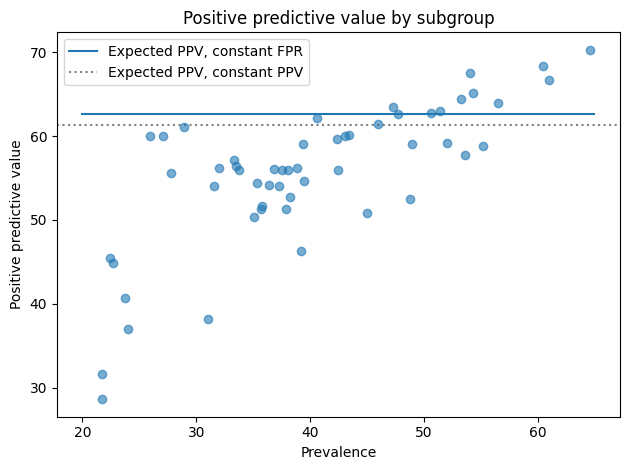

<IPython.core.display.Javascript object>

In [30]:
pred_pv["ppv"].plot(label="Expected PPV, constant FPR", color="C0")
plt.axhline(ppv, linestyle="dotted", color="gray", label="Expected PPV, constant PPV")

for table in tables:
    plot_table_var(table, "PPV", "C0")

decorate(
    xlabel="Prevalence",
    ylabel="Positive predictive value",
    title="Positive predictive value by subgroup",
)

Groups with higher prevalence have higher PPV, but the effect is less extreme than we would expect from the CPV model.

Here are the results for false negative rate.

Groups with higher prevalence have lower FNR, but the effect is less extreme than we would expect from the CPV model.

Here are the results for negative predictive value.

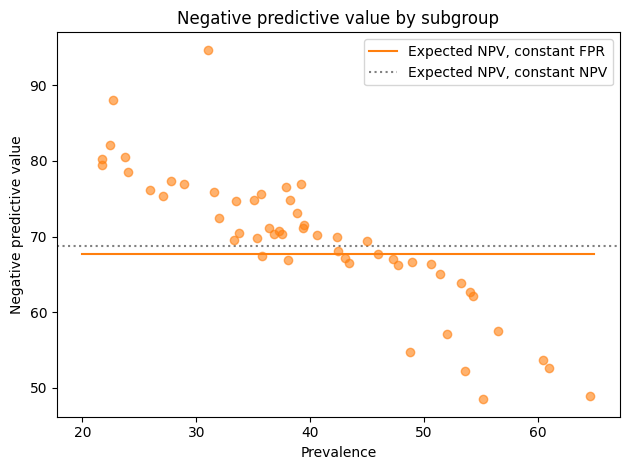

<IPython.core.display.Javascript object>

In [31]:
pred_pv["npv"].plot(label="Expected NPV, constant FPR", color="C1")
plt.axhline(npv, linestyle="dotted", color="gray", label="Expected NPV, constant NPV")

for table in tables:
    plot_table_var(table, "NPV", "C1")

decorate(
    xlabel="Prevalence",
    ylabel="Negative predictive value",
    title="Negative predictive value by subgroup",
)

Groups with higher prevalence have lower NPV.  In this case, the effect is almost exactly what we would expect from the CPV model.

Part of a [Recidivism Case Study](https://allendowney.github.io/RecidivismCaseStudy/)

by [Allen Downey](https://allendowney.com)

[Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/)